In [2]:
import os
import re
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
import kagglehub

In [3]:

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stanford-dogs-dataset


In [7]:
# src = "/kaggle/input/stanford-dogs-dataset"
# dst = "/content/drive/MyDrive/ML_notes/Final_project/dog_data"   # pick your folder name
# shutil.copytree(src, dst)
# print("Copied to:", dst)


Copied to: /content/drive/MyDrive/ML_notes/Final_project/dog_data


In [4]:

# 1. Source (read‐only) and destination (writeable) roots
src_root = '/kaggle/input/stanford-dogs-dataset/images/Images'
dst_root = '/kaggle/working/Images_renamed'

os.makedirs(dst_root, exist_ok=True)

# 2. Iterate over each class folder in src_root
for old_name in os.listdir(src_root):
    old_path = os.path.join(src_root, old_name)
    if not os.path.isdir(old_path):
        continue

    # 3. Capture the part after the first dash
    m = re.match(r'^[^-]+-(.+)$', old_name)
    if not m:
        # if no dash, just keep the original name
        new_name = old_name
    else:
        new_name = m.group(1)

    dst_path = os.path.join(dst_root, new_name)

    # 4. Copy (and thus “rename”) in one step
    print(f'Copying "{old_name}" → "{new_name}"')
    shutil.copytree(old_path, dst_path)

print("All folders copied and renamed to:", dst_root)

Copying "n02091635-otterhound" → "otterhound"
Copying "n02102318-cocker_spaniel" → "cocker_spaniel"
Copying "n02101388-Brittany_spaniel" → "Brittany_spaniel"
Copying "n02088094-Afghan_hound" → "Afghan_hound"
Copying "n02085936-Maltese_dog" → "Maltese_dog"
Copying "n02104365-schipperke" → "schipperke"
Copying "n02100877-Irish_setter" → "Irish_setter"
Copying "n02086079-Pekinese" → "Pekinese"
Copying "n02099601-golden_retriever" → "golden_retriever"
Copying "n02100583-vizsla" → "vizsla"
Copying "n02102177-Welsh_springer_spaniel" → "Welsh_springer_spaniel"
Copying "n02093256-Staffordshire_bullterrier" → "Staffordshire_bullterrier"
Copying "n02106166-Border_collie" → "Border_collie"
Copying "n02093991-Irish_terrier" → "Irish_terrier"
Copying "n02109961-Eskimo_dog" → "Eskimo_dog"
Copying "n02110958-pug" → "pug"
Copying "n02105412-kelpie" → "kelpie"
Copying "n02094433-Yorkshire_terrier" → "Yorkshire_terrier"
Copying "n02097474-Tibetan_terrier" → "Tibetan_terrier"
Copying "n02089867-Walker_ho

In [5]:

# Set memory growth for GPU (prevents OOM errors)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [6]:
# ─── PARAMETERS ────────────────────────────────────────────────────────────────
SIZE = (299, 299)  # Default size for Xception
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
EPOCHS = 10
SEED = 42

In [7]:
# ─── SETUP PATHS ─────────────────────────────────────────────────────────────────
# For Kaggle paths
orig_data_dir = "/kaggle/working/Images_renamed"
split_root = "/kaggle/working/Split_dataset"

train_dir = os.path.join(split_root, "train")
val_dir = os.path.join(split_root, "val")
test_dir = os.path.join(split_root, "test")

# Create directories
os.makedirs(split_root, exist_ok=True)
for d in (train_dir, val_dir, test_dir):
    os.makedirs(d, exist_ok=True)

In [8]:




# ─── SPLIT DATA ─────────────────────────────────────────────────────────────────
print("Splitting dataset...")

# Split percentages
train_frac = 0.70
val_frac = 0.15
test_frac = 0.15

for breed in os.listdir(orig_data_dir):
    breed_src = os.path.join(orig_data_dir, breed)
    if not os.path.isdir(breed_src):
        continue

    print(f"Processing: {breed}")

    # Get image files
    imgs = [f for f in os.listdir(breed_src) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # Split into train/val/test
    train_imgs, holdout = train_test_split(
        imgs, train_size=train_frac, random_state=SEED, shuffle=True
    )
    val_imgs, test_imgs = train_test_split(
        holdout, test_size=test_frac/(val_frac+test_frac),
        random_state=SEED, shuffle=True
    )

    # Copy files
    for subset, dest_dir in zip([train_imgs, val_imgs, test_imgs], [train_dir, val_dir, test_dir]):
        dest_breed_dir = os.path.join(dest_dir, breed)
        os.makedirs(dest_breed_dir, exist_ok=True)

        for img in subset:
            shutil.copy(os.path.join(breed_src, img), os.path.join(dest_breed_dir, img))

print("\nData split complete:")
print(" train:", sum(len(files) for r, d, files in os.walk(train_dir)))
print("  val:", sum(len(files) for r, d, files in os.walk(val_dir)))
print(" test:", sum(len(files) for r, d, files in os.walk(test_dir)))

Splitting dataset...
Processing: Irish_water_spaniel
Processing: Yorkshire_terrier
Processing: African_hunting_dog
Processing: Scottish_deerhound
Processing: Chihuahua
Processing: German_short-haired_pointer
Processing: standard_schnauzer
Processing: basset
Processing: Mexican_hairless
Processing: vizsla
Processing: West_Highland_white_terrier
Processing: Scotch_terrier
Processing: Great_Dane
Processing: kelpie
Processing: Walker_hound
Processing: Eskimo_dog
Processing: cocker_spaniel
Processing: English_springer
Processing: Siberian_husky
Processing: Border_collie
Processing: Japanese_spaniel
Processing: Old_English_sheepdog
Processing: briard
Processing: miniature_poodle
Processing: curly-coated_retriever
Processing: Rottweiler
Processing: German_shepherd
Processing: Cardigan
Processing: Appenzeller
Processing: Chesapeake_Bay_retriever
Processing: Boston_bull
Processing: Pekinese
Processing: redbone
Processing: groenendael
Processing: collie
Processing: basenji
Processing: komondor
P

In [9]:


# ─── CREATE DATA GENERATORS ──────────────────────────────────────────────────────
# Simple rescaling only - add augmentation later if needed
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print(f"Number of classes: {num_classes}")

Found 14355 images belonging to 120 classes.
Found 3083 images belonging to 120 classes.
Found 3142 images belonging to 120 classes.
Number of classes: 120


In [10]:

# ─── BUILD MODEL ─────────────────────────────────────────────────────────────────
# Simple model with frozen Xception base
inp = Input(shape=(SIZE[0], SIZE[1], 3))
base_model = Xception(weights='imagenet', include_top=False, input_tensor=inp)
base_model.trainable = False

# Simple classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inp, outputs=output)

# Compile with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 21,107,360 (80.52 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [11]:

# ─── TRAIN MODEL ────────────────────────────────────────────────────────────────
# Setup checkpointing
checkpoint_dir = '/kaggle/working/model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.h5')

# Callbacks for training
callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]



# Calculate steps per epoch and validation steps
steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE

# Make sure steps are at least 1
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

print(f"Training with {steps_per_epoch} steps per epoch and {validation_steps} validation steps")

# Train model
print("\nStarting training...")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Training with 448 steps per epoch and 96 validation steps

Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5711 - loss: 2.2269
Epoch 1: val_accuracy improved from -inf to 0.89421, saving model to /kaggle/working/model_checkpoints/best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 151ms/step - accuracy: 0.5716 - loss: 2.2246 - val_accuracy: 0.8942 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 2/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.8125 - loss: 0.5033

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.89421
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8125 - loss: 0.5033 - val_accuracy: 0.8939 - val_loss: 0.4051 - learning_rate: 0.0010
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8912 - loss: 0.3955
Epoch 3: val_accuracy did not improve from 0.89421
448/448 ━━━━━━━━━━━━━━━━━━━━ 54s 121ms/step - accuracy: 0.8912 - loss: 0.3955 - val_accuracy: 0.8903 - val_loss: 0.3543 - learning_rate: 0.0010
Epoch 4/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.8750 - loss: 0.4766
Epoch 4: val_accuracy did not improve from 0.89421
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8750 - loss: 0.4766 - val_accuracy: 0.8900 - val_loss: 0.3543 - learning_rate: 0.0010
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9013 - loss: 0.3181
Epoch 5: val_accuracy improved from 0.89421 to 0.90104, saving model to /kaggle/working/model_checkpoints/best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 54s 121ms/step - accuracy: 0.9013 - loss: 0.3181 - val_accuracy: 0.9010 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 6/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.7500 - loss: 0.5029
Epoch 6: val_accuracy improved from 0.90104 to 0.90202, saving model to /kaggle/working/model_checkpoints/best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7500 - loss: 0.5029 - val_accuracy: 0.9020 - val_loss: 0.3382 - learning_rate: 0.0010
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9069 - loss: 0.2911
Epoch 7: val_accuracy did not improve from 0.90202
448/448 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step - accuracy: 0.9069 - loss: 0.2911 - val_accuracy: 0.8936 - val_loss: 0.3392 - learning_rate: 0.0010
Epoch 8/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9375 - loss: 0.2176
Epoch 8: val_accuracy did not improve from 0.90202

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9375 - loss: 0.2176 - val_accuracy: 0.8929 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9164 - loss: 0.2521
Epoch 9: val_accuracy did not improve from 0.90202
448/448 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.9164 - loss: 0.2521 -

In [12]:

# ─── EVALUATE ───────────────────────────────────────────────────────────────────
loss, accuracy = model.evaluate(test_gen, steps=test_gen.samples // BATCH_SIZE)
print(f"\nTest loss: {loss:.4f}\nTest accuracy: {accuracy:.4f}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9040 - loss: 0.2984

Test loss: 0.3211
Test accuracy: 0.8973


In [14]:
 #Source file
src = '/kaggle/working/model_checkpoints/best_model.h5'

# Destination directory (adjust path if needed)
dst_dir = '/content/drive/MyDrive/ML_notes/Final_project/dog_models'
os.makedirs(dst_dir, exist_ok=True)

# Full destination path
dst = os.path.join(dst_dir, 'best_model.h5')

# Copy
shutil.copy(src, dst)
print(f'Copied:\n  {src}\nto\n  {dst}')

Copied:
  /kaggle/working/model_checkpoints/best_model.h5
to
  /content/drive/MyDrive/ML_notes/Final_project/dog_models/best_model.h5


In [15]:
import matplotlib.pyplot as plt


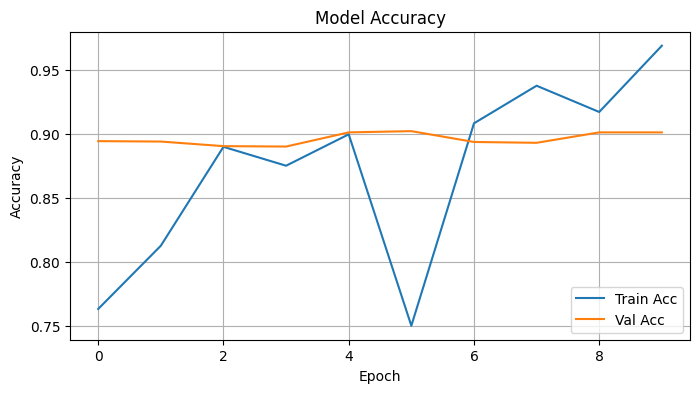

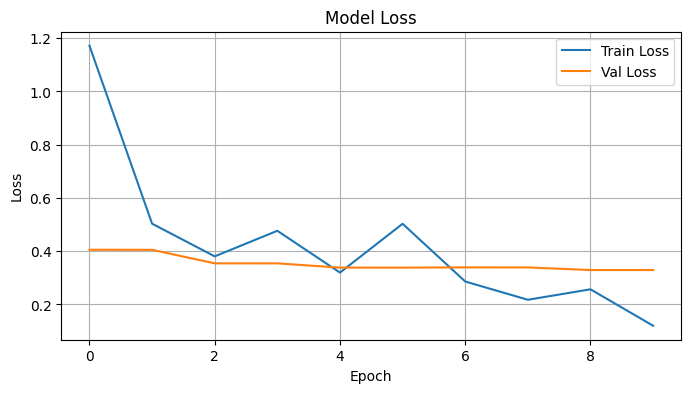

In [18]:
 #Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:

# ─── STEP 8: SAVE MODEL AND CLASS NAMES ───────────────────────────────────────
# Get class indices and create a mapping dict
class_indices = train_gen.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Save class names
import json
with open('/content/drive/MyDrive/ML_notes/Final_project/dog_models/class_names.json', 'w') as f:
    json.dump(class_names, f)

# Save the model in TensorFlow SavedModel format
# model.save('models/dog_breed_model')

print("\nTraining complete!")
print(f"Model saved to: models/dog_breed_model")
print(f"Best weights saved to: {checkpoint_path}")
print(f"Class names saved to: models/class_names.json")

In [19]:
class_indices = train_gen.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Save class names
import json
with open('/content/drive/MyDrive/ML_notes/Final_project/dog_models/class_names.json', 'w') as f:
    json.dump(class_names, f)

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [23]:
# 1) Load your class→index mapping
with open('/content/drive/MyDrive/ML_notes/Final_project/dog_models/class_names.json', 'r') as f:
    class_map = json.load(f)

# if class_map is { "breed_name": index, … }, invert it:
if all(isinstance(v, int) for v in class_map.values()):
    idx_to_class = {v: k for k, v in class_map.items()}
else:
    # if it’s already { "0": "breed_name", … } convert keys to int
    idx_to_class = {int(k): v for k, v in class_map.items()}

# 2) Load your trained model
model = load_model('/content/drive/MyDrive/ML_notes/Final_project/dog_models/best_model.h5', compile= False)

# 3) Preprocess the image
img_path = '/content/drive/MyDrive/ML_notes/Final_project/dog_data/images/Images/n02085620-Chihuahua/n02085620_10074.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x   = image.img_to_array(img)
x  /= 255.0
x   = np.expand_dims(x, axis=0)   # shape → (1, 299, 299, 3)

# 4) Make prediction
preds      = model.predict(x)        # shape = (1, num_classes)
pred_index = np.argmax(preds[0])
pred_prob  = preds[0][pred_index]

# 5) Map back to breed name
pred_breed = idx_to_class[pred_index]

print(f"Predicted breed: {pred_breed}")
print(f"Confidence: {pred_prob*100:.1f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted breed: Chihuahua
Confidence: 99.1%


In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


Found 3083 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step
Overall accuracy: 0.9020


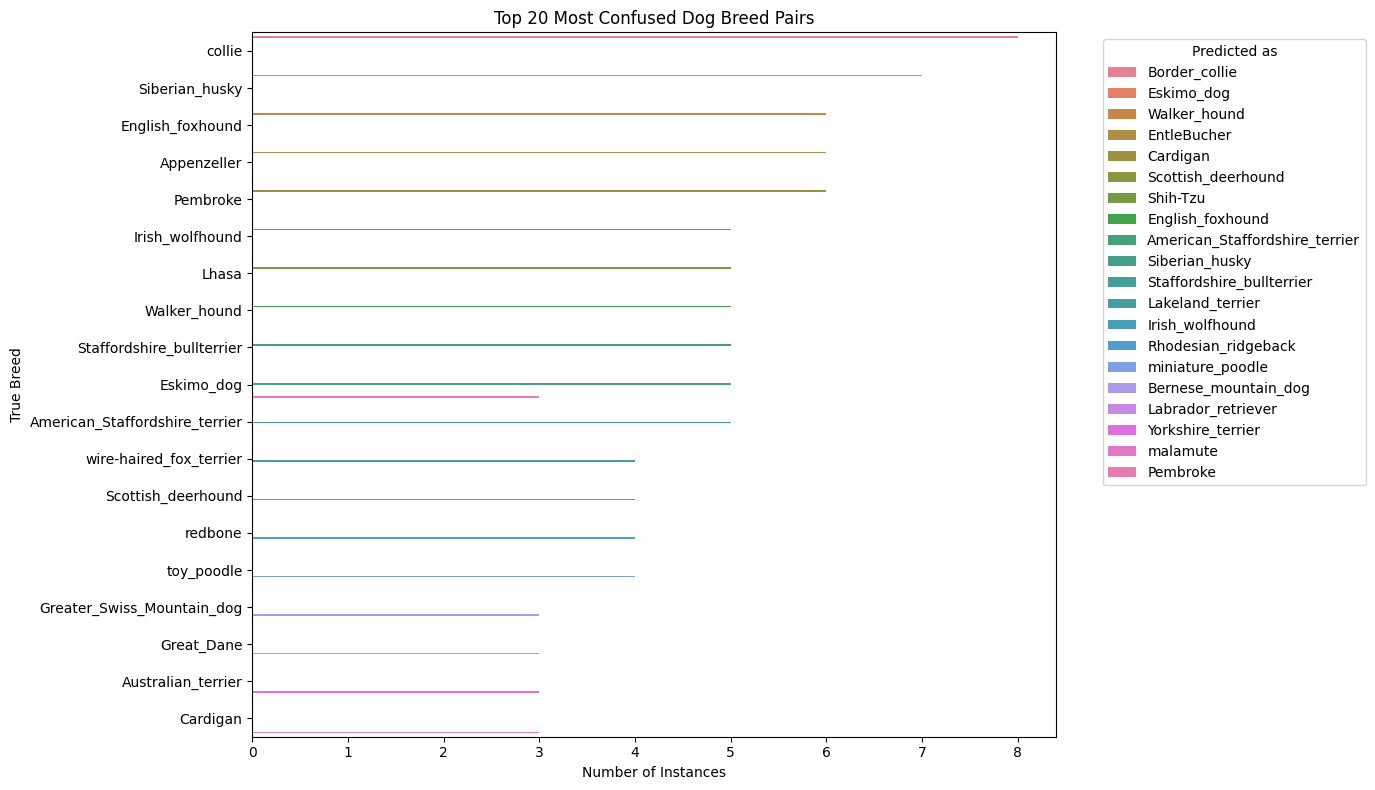

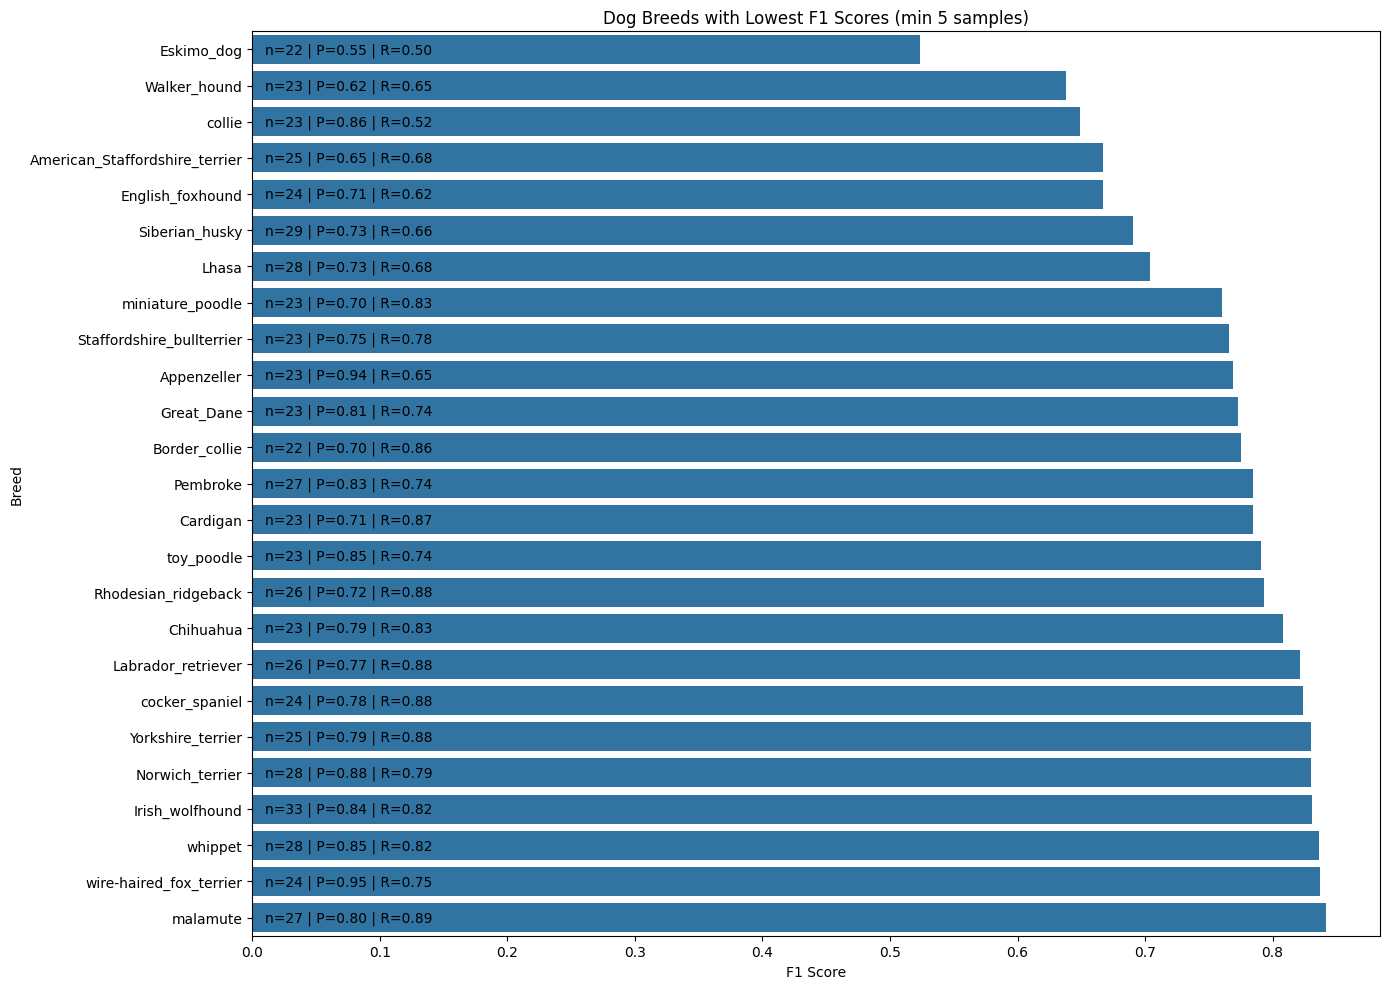

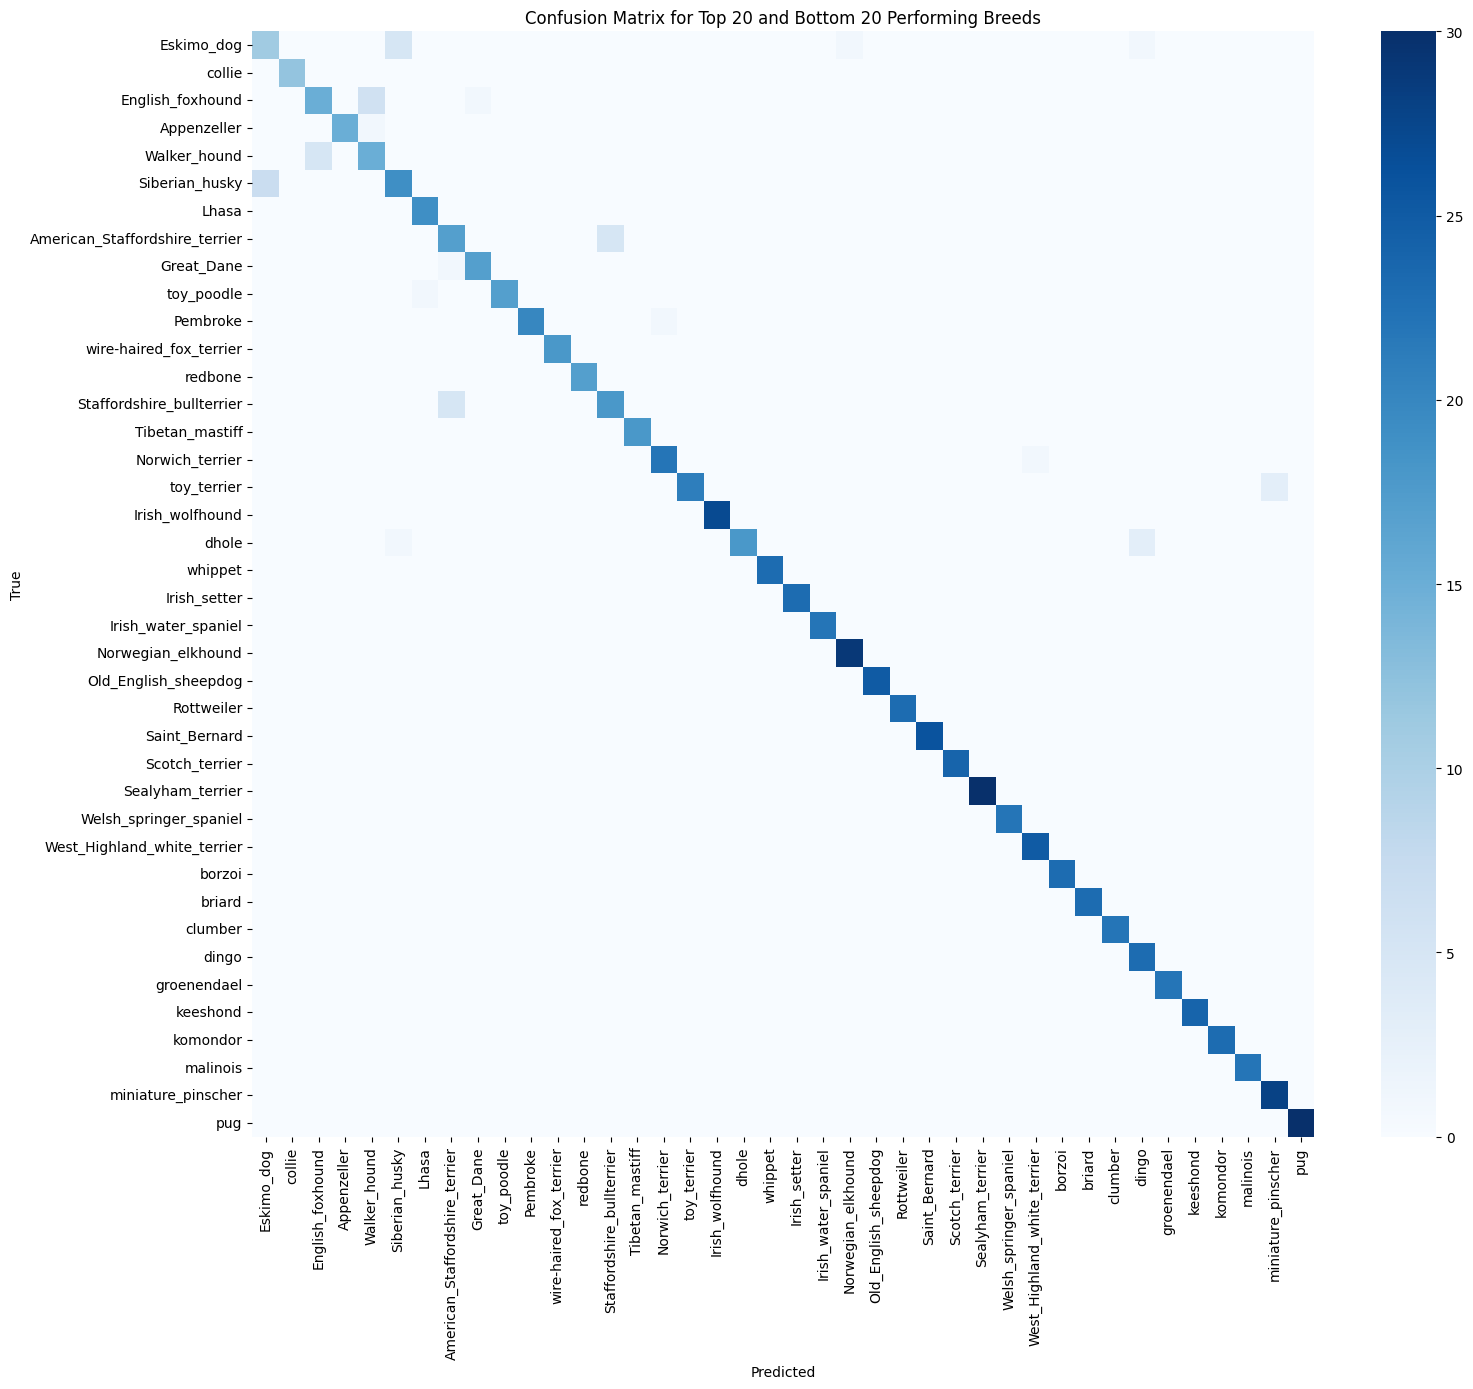

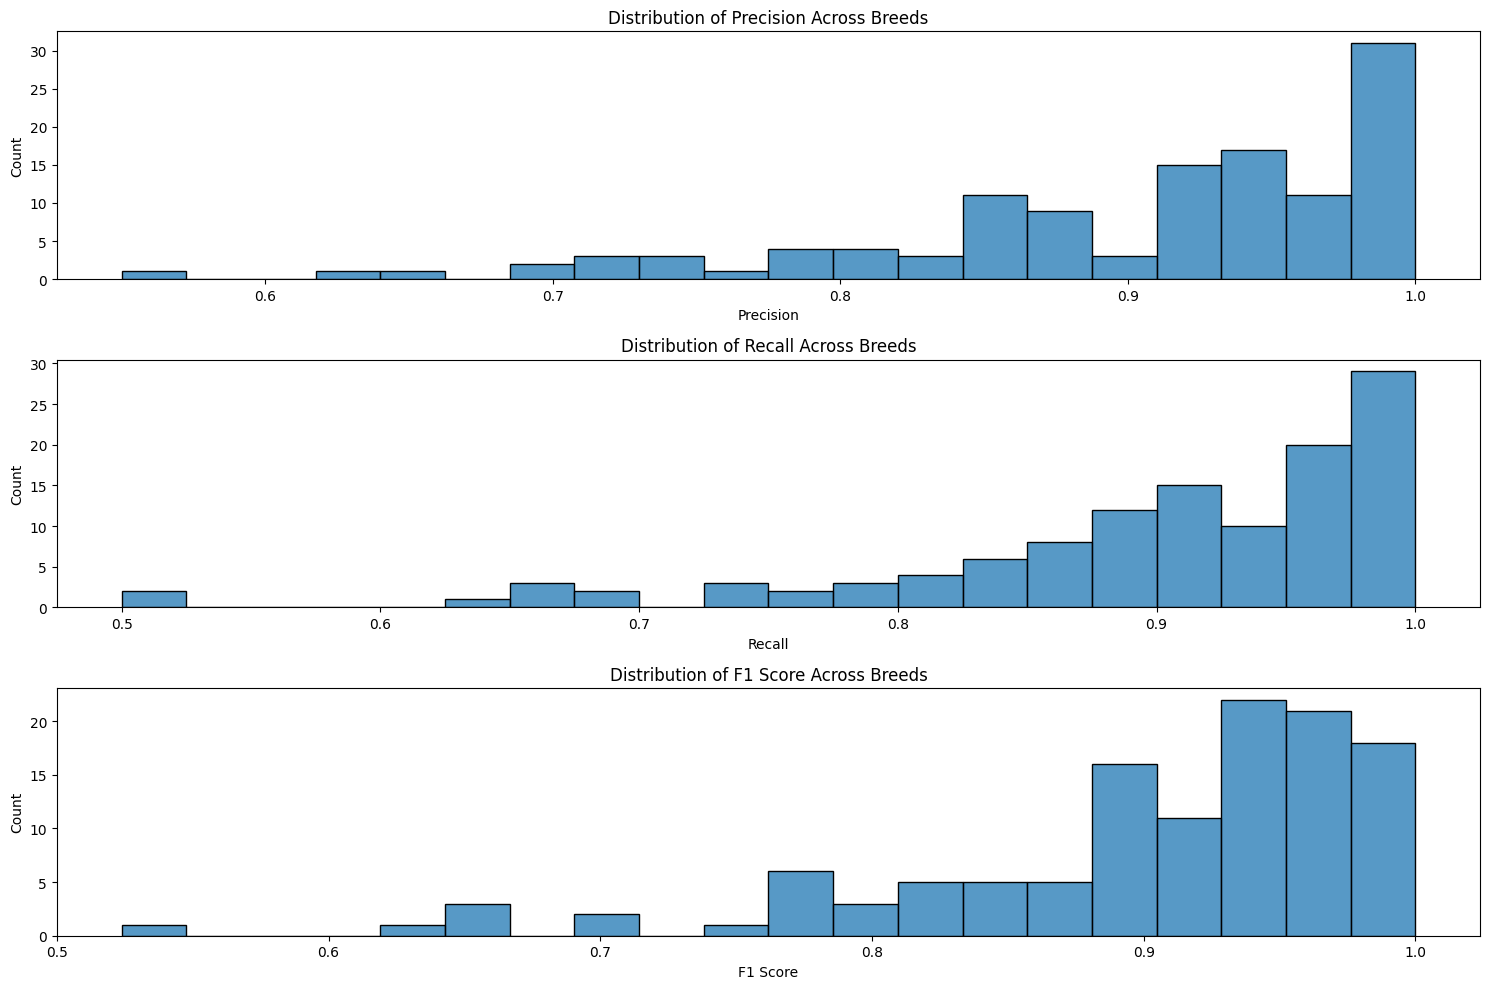

In [27]:
# 1) Re-create a generator with shuffle=False
val_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important!
)

# 2) Get true labels
y_true = val_eval_gen.classes                 # array of ints, one per image

# 3) Predict
y_prob = model.predict(
    val_eval_gen,
    steps = np.ceil(val_eval_gen.samples / BATCH_SIZE).astype(int)
)
y_pred = np.argmax(y_prob, axis=1)

# 4) Get class names
labels = list(val_eval_gen.class_indices.keys())  # list of class names in index order

# 5) Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall accuracy: {accuracy:.4f}")

# 6) Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 7) Calculate per-class metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate precision, recall, and f1-score for each class
class_metrics = []
for i in range(len(labels)):
    true_positives = cm[i, i]
    false_positives = np.sum(cm[:, i]) - true_positives
    false_negatives = np.sum(cm[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    sample_count = np.sum(cm[i, :])

    class_metrics.append({
        'Breed': labels[i],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Samples': sample_count
    })

metrics_df = pd.DataFrame(class_metrics)

# 8) Visualization 1: Top 20 most confused pairs
confusion_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True': labels[i],
                'Predicted': labels[j],
                'Count': cm[i, j]
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)

plt.figure(figsize=(14, 8))
top_confused = confusion_df.head(20)
ax = sns.barplot(x='Count', y='True', hue='Predicted', data=top_confused)
plt.title('Top 20 Most Confused Dog Breed Pairs')
plt.xlabel('Number of Instances')
plt.ylabel('True Breed')
plt.legend(title='Predicted as', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('top_confused_pairs.png')
plt.show()

# 9) Visualization 2: Worst performing breeds (lowest F1 score)
# Filter out breeds with too few samples
min_samples = 5
filtered_metrics = metrics_df[metrics_df['Samples'] >= min_samples].sort_values('F1')

plt.figure(figsize=(14, 10))
bottom_f1 = filtered_metrics.head(25)
ax = sns.barplot(x='F1', y='Breed', data=bottom_f1)
plt.title('Dog Breeds with Lowest F1 Scores (min 5 samples)')
plt.xlabel('F1 Score')
plt.ylabel('Breed')

# Add sample count and precision/recall to the labels
for i, row in enumerate(bottom_f1.itertuples()):
    ax.text(0.01, i, f"n={row.Samples} | P={row.Precision:.2f} | R={row.Recall:.2f}", va='center')

plt.tight_layout()
plt.savefig('worst_performing_breeds.png')
plt.show()

# 10) Visualization 3: Heat map of the diagonal (correct classifications)
# Create a diagonal matrix
diag_matrix = np.diag(np.diag(cm))
diag_df = pd.DataFrame(diag_matrix, columns=labels, index=labels)

# Sort breeds by accuracy
breed_accuracy = []
for i in range(len(labels)):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    acc = correct / total if total > 0 else 0
    breed_accuracy.append((labels[i], acc, total))

# Sort by accuracy
breed_accuracy.sort(key=lambda x: x[1])
sorted_labels = [x[0] for x in breed_accuracy]

# Take top and bottom 20 breeds for comparison
top_20 = sorted_labels[-20:]
bottom_20 = sorted_labels[:20]
selected_breeds = bottom_20 + top_20

# Extract the relevant part of the confusion matrix
selected_indices = [labels.index(breed) for breed in selected_breeds]
selected_cm = cm[selected_indices, :][:, selected_indices]

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(selected_cm, xticklabels=selected_breeds, yticklabels=selected_breeds,
           cmap="Blues", annot=False)
plt.title('Confusion Matrix for Top 20 and Bottom 20 Performing Breeds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('selected_confusion_matrix.png')
plt.show()

# 11) Visualization 4: Distribution of metrics across all breeds
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.histplot(metrics_df['Precision'], bins=20)
plt.title('Distribution of Precision Across Breeds')
plt.xlabel('Precision')
plt.ylabel('Count')

plt.subplot(3, 1, 2)
sns.histplot(metrics_df['Recall'], bins=20)
plt.title('Distribution of Recall Across Breeds')
plt.xlabel('Recall')
plt.ylabel('Count')

plt.subplot(3, 1, 3)
sns.histplot(metrics_df['F1'], bins=20)
plt.title('Distribution of F1 Score Across Breeds')
plt.xlabel('F1 Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('metric_distributions.png')
plt.show()

In [28]:
# 1) First, perform your evaluation as before
val_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important!
)

# Get true labels
y_true = val_eval_gen.classes
class_indices = val_eval_gen.class_indices
labels = list(class_indices.keys())

# Predict
y_prob = model.predict(
    val_eval_gen,
    steps = np.ceil(val_eval_gen.samples / BATCH_SIZE).astype(int)
)
y_pred = np.argmax(y_prob, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 2) Save the basic results to CSV files
import pandas as pd
import json
import pickle
import os

# Create a directory for saving evaluation results
results_dir = '/content/drive/MyDrive/ML_notes/Final_project/dog_models'
os.makedirs(results_dir, exist_ok=True)

# Save class indices mapping
with open(f'{results_dir}/class_indices.json', 'w') as f:
    json.dump(class_indices, f)

# Save true and predicted labels
results_df = pd.DataFrame({
    'true_label': [labels[i] for i in y_true],
    'true_label_index': y_true,
    'predicted_label': [labels[i] for i in y_pred],
    'predicted_label_index': y_pred,
})
results_df.to_csv(f'{results_dir}/prediction_results.csv', index=False)

# Save probabilities (useful for ROC curves, etc.)
prob_df = pd.DataFrame(y_prob, columns=[labels[i] for i in range(len(labels))])
prob_df.to_csv(f'{results_dir}/prediction_probabilities.csv', index=False)

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df.to_csv(f'{results_dir}/confusion_matrix.csv')

# 3) Save detailed per-class metrics
# Calculate precision, recall, and f1-score for each class
class_metrics = []
for i in range(len(labels)):
    true_positives = cm[i, i]
    false_positives = np.sum(cm[:, i]) - true_positives
    false_negatives = np.sum(cm[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    sample_count = np.sum(cm[i, :])

    class_metrics.append({
        'Breed': labels[i],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Samples': sample_count,
        'True_Positives': true_positives,
        'False_Positives': false_positives,
        'False_Negatives': false_negatives
    })

metrics_df = pd.DataFrame(class_metrics)
metrics_df.to_csv(f'{results_dir}/class_metrics.csv', index=False)

# 4) Save most confused pairs
confusion_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True': labels[i],
                'Predicted': labels[j],
                'Count': cm[i, j]
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)
confusion_df.to_csv(f'{results_dir}/confusion_pairs.csv', index=False)

# 5) Save raw data in pickle format for more complex analysis later
# This preserves all data structures including numpy arrays
evaluation_data = {
    'y_true': y_true,
    'y_pred': y_pred,
    'y_prob': y_prob,
    'labels': labels,
    'class_indices': class_indices,
    'confusion_matrix': cm,
    'class_metrics': class_metrics
}

with open(f'{results_dir}/evaluation_data.pkl', 'wb') as f:
    pickle.dump(evaluation_data, f)

print(f"Evaluation results saved to '{results_dir}' directory")
print(f"Files saved:")
print(f"  - class_indices.json: Mapping between class indices and breed names")
print(f"  - prediction_results.csv: True and predicted labels for each sample")
print(f"  - prediction_probabilities.csv: Probability scores for each class")
print(f"  - confusion_matrix.csv: Full confusion matrix")
print(f"  - class_metrics.csv: Precision, recall, F1, etc. for each breed")
print(f"  - confusion_pairs.csv: Most confused breed pairs")
print(f"  - evaluation_data.pkl: Complete evaluation data in Python pickle format")

Found 3083 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step
Evaluation results saved to '/content/drive/MyDrive/ML_notes/Final_project/dog_models' directory
Files saved:
  - class_indices.json: Mapping between class indices and breed names
  - prediction_results.csv: True and predicted labels for each sample
  - prediction_probabilities.csv: Probability scores for each class
  - confusion_matrix.csv: Full confusion matrix
  - class_metrics.csv: Precision, recall, F1, etc. for each breed
  - confusion_pairs.csv: Most confused breed pairs
  - evaluation_data.pkl: Complete evaluation data in Python pickle format


In [29]:
import os
import numpy as np
import pandas as pd
import json
import pickle
from sklearn.metrics import confusion_matrix

# Create a directory for saving evaluation results
# Create a directory for saving evaluation results
results_dir = '/content/drive/MyDrive/ML_notes/Final_project/dog_models/results'
os.makedirs(results_dir, exist_ok=True)


# Define a function to evaluate and save results for a dataset
def evaluate_and_save(dataset_name, directory, batch_size, model, size):
    print(f"\nEvaluating model on {dataset_name} set...")

    # Create generator for evaluation
    eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory,
        target_size=size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Get true labels and class indices
    y_true = eval_gen.classes
    class_indices = eval_gen.class_indices
    labels = list(class_indices.keys())

    # Get predictions
    y_prob = model.predict(
        eval_gen,
        steps=np.ceil(eval_gen.samples / batch_size).astype(int)
    )
    y_pred = np.argmax(y_prob, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    # Create subdirectory for this dataset
    dataset_dir = os.path.join(results_dir, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)

    # Save class indices mapping
    with open(f'{dataset_dir}/class_indices.json', 'w') as f:
        json.dump(class_indices, f)

    # Save true and predicted labels
    results_df = pd.DataFrame({
        'true_label': [labels[i] for i in y_true],
        'true_label_index': y_true,
        'predicted_label': [labels[i] for i in y_pred],
        'predicted_label_index': y_pred,
    })
    results_df.to_csv(f'{dataset_dir}/prediction_results.csv', index=False)

    # Save probabilities
    prob_df = pd.DataFrame(y_prob, columns=[labels[i] for i in range(len(labels))])
    prob_df.to_csv(f'{dataset_dir}/prediction_probabilities.csv', index=False)

    # Save confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.to_csv(f'{dataset_dir}/confusion_matrix.csv')

    # Calculate and save per-class metrics
    class_metrics = []
    for i in range(len(labels)):
        true_positives = cm[i, i]
        false_positives = np.sum(cm[:, i]) - true_positives
        false_negatives = np.sum(cm[i, :]) - true_positives

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        sample_count = np.sum(cm[i, :])

        class_metrics.append({
            'Breed': labels[i],
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Samples': sample_count,
            'True_Positives': true_positives,
            'False_Positives': false_positives,
            'False_Negatives': false_negatives
        })

    metrics_df = pd.DataFrame(class_metrics)
    metrics_df.to_csv(f'{dataset_dir}/class_metrics.csv', index=False)

    # Save most confused pairs
    confusion_pairs = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append({
                    'True': labels[i],
                    'Predicted': labels[j],
                    'Count': cm[i, j]
                })

    confusion_df = pd.DataFrame(confusion_pairs)
    confusion_df = confusion_df.sort_values('Count', ascending=False)
    confusion_df.to_csv(f'{dataset_dir}/confusion_pairs.csv', index=False)

    # Save raw data in pickle format
    evaluation_data = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'labels': labels,
        'class_indices': class_indices,
        'confusion_matrix': cm,
        'class_metrics': class_metrics
    }

    with open(f'{dataset_dir}/evaluation_data.pkl', 'wb') as f:
        pickle.dump(evaluation_data, f)

    # Calculate overall accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"{dataset_name} accuracy: {accuracy:.4f}")

    # Return evaluation data
    return evaluation_data

# Evaluate all three datasets
train_eval = evaluate_and_save('train', train_dir, BATCH_SIZE, model, SIZE)
val_eval = evaluate_and_save('validation', val_dir, BATCH_SIZE, model, SIZE)
test_eval = evaluate_and_save('test', test_dir, BATCH_SIZE, model, SIZE)

# Save comparative metrics across datasets
comparative = {
    'train_accuracy': np.sum(train_eval['y_true'] == train_eval['y_pred']) / len(train_eval['y_true']),
    'val_accuracy': np.sum(val_eval['y_true'] == val_eval['y_pred']) / len(val_eval['y_true']),
    'test_accuracy': np.sum(test_eval['y_true'] == test_eval['y_pred']) / len(test_eval['y_true']),
}

# Calculate per-class comparative metrics
all_breeds = sorted(list(set(train_eval['labels'])))
comparative_metrics = []

for breed in all_breeds:
    train_idx = train_eval['labels'].index(breed) if breed in train_eval['labels'] else None
    val_idx = val_eval['labels'].index(breed) if breed in val_eval['labels'] else None
    test_idx = test_eval['labels'].index(breed) if breed in test_eval['labels'] else None

    train_f1 = train_eval['class_metrics'][train_idx]['F1'] if train_idx is not None else 0
    val_f1 = val_eval['class_metrics'][val_idx]['F1'] if val_idx is not None else 0
    test_f1 = test_eval['class_metrics'][test_idx]['F1'] if test_idx is not None else 0

    train_samples = train_eval['class_metrics'][train_idx]['Samples'] if train_idx is not None else 0
    val_samples = val_eval['class_metrics'][val_idx]['Samples'] if val_idx is not None else 0
    test_samples = test_eval['class_metrics'][test_idx]['Samples'] if test_idx is not None else 0

    comparative_metrics.append({
        'Breed': breed,
        'Train_F1': train_f1,
        'Val_F1': val_f1,
        'Test_F1': test_f1,
        'Train_Samples': train_samples,
        'Val_Samples': val_samples,
        'Test_Samples': test_samples
    })

comparative_df = pd.DataFrame(comparative_metrics)
comparative_df.to_csv(f'{results_dir}/comparative_metrics.csv', index=False)

# Save summary metrics
summary = {
    'dataset_sizes': {
        'train': len(train_eval['y_true']),
        'validation': len(val_eval['y_true']),
        'test': len(test_eval['y_true'])
    },
    'overall_accuracy': {
        'train': comparative['train_accuracy'],
        'validation': comparative['val_accuracy'],
        'test': comparative['test_accuracy']
    },
    'avg_class_f1': {
        'train': np.mean([m['F1'] for m in train_eval['class_metrics']]),
        'validation': np.mean([m['F1'] for m in val_eval['class_metrics']]),
        'test': np.mean([m['F1'] for m in test_eval['class_metrics']])
    }
}

with open(f'{results_dir}/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nEvaluation complete. Results saved to the 'evaluation_results' directory.")
print("\nSummary:")
print(f"  Train accuracy: {comparative['train_accuracy']:.4f}")
print(f"  Validation accuracy: {comparative['val_accuracy']:.4f}")
print(f"  Test accuracy: {comparative['test_accuracy']:.4f}")


Evaluating model on train set...
Found 14355 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step
train accuracy: 0.9320

Evaluating model on validation set...
Found 3083 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step
validation accuracy: 0.9020

Evaluating model on test set...
Found 3142 images belonging to 120 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step
test accuracy: 0.8940

Evaluation complete. Results saved to the 'evaluation_results' directory.

Summary:
  Train accuracy: 0.9320
  Validation accuracy: 0.9020
  Test accuracy: 0.8940
